In [1]:
# TAKEN FROM : https://github.com/AI4Finance-Foundation/FinRL/blob/master/examples/FinRL_GPM_Demo.ipynb

In [ ]:
!pip install quantstats

In [ ]:
!pip install torch-geometric

In [ ]:
!pip install gym

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [4]:
import torch

import numpy as np
import pandas as pd

from torch_geometric.utils import k_hop_subgraph

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import GPM

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

2024-12-03 13:03:43.954845: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 13:03:43.978100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733205824.002345  622064 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733205824.009969  622064 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 13:03:44.042329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!curl -L -O https://github.com/C4i0kun/Temporal_Relational_Stock_Ranking_FinRL/archive/refs/heads/main.zip
# !unzip Temporal_Relational_Stock_Ranking_FinRL-main.zip

In [12]:
!unzip main.zip
!mv Temporal_Relational_Stock_Ranking_FinRL-main Temporal_Relational_Stock_Ranking_FinRL
!tar -xzvf Temporal_Relational_Stock_Ranking_FinRL/temporal_data/temporal_data_processed.tar.gz -C Temporal_Relational_Stock_Ranking_FinRL/temporal_data

Archive:  main.zip
b0a94b8166432fd6440899e8111aaef24f5cff62
   creating: Temporal_Relational_Stock_Ranking_FinRL-main/
 extracting: Temporal_Relational_Stock_Ranking_FinRL-main/.gitignore  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/LICENSE  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/README.md  
   creating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/
   creating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/NASDAQ_wikidata_edge_index.npy  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/NYSE_sector_industry_edge_index.npy  
  inflating: Temporal_Relational_Stock_Ranking_FinRL-main/relational_data/edge_indexes/NYSE_wikidata_edge_index.npy  
   creating: Tempor

In [5]:
nasdaq_temporal = pd.read_csv("Temporal_Relational_Stock_Ranking_FinRL/temporal_data/NASDAQ_temporal_data.csv")
nasdaq_temporal

,day,open,high,low,close,volume,tic
0,0,0.270533,0.269522,0.267237,0.263333,0.275333,AABA
1,0,0.238730,0.237522,0.239888,0.240502,0.248031,AAON
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
3,0,0.650667,0.648412,0.634492,0.631473,0.667839,AAWW
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
...,...,...,...,...,...,...,...
1277365,1244,0.909992,0.918809,0.912345,0.922698,0.913021,ZBRA
1277366,1244,0.660990,0.648907,0.636086,0.630816,0.665167,ZEUS
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION
1277368,1244,0.980227,0.974903,0.960225,0.964956,0.997580,ZIV


In [6]:
nasdaq_edge_index = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_indexes/NASDAQ_sector_industry_edge_index.npy")
nasdaq_edge_index

array([[   0,   15,    0, ..., 1021, 1014, 1024],
       [  15,    0,   18, ..., 1011, 1024, 1014]])

In [7]:
nasdaq_edge_type = np.load("Temporal_Relational_Stock_Ranking_FinRL/relational_data/edge_types/NASDAQ_sector_industry_edge_type.npy")
nasdaq_edge_type

array([ 0,  0,  0, ...,  1, 26, 26])

In [8]:
list_of_stocks = nasdaq_temporal["tic"].unique().tolist()
tics_in_portfolio = ["AAPL", "CMCSA", "CSCO", "FB", "HBAN", "INTC", "MSFT", "MU", "NVDA", "QQQ", "XIV"]

portfolio_nodes = []
for tic in tics_in_portfolio:
    portfolio_nodes.append(list_of_stocks.index(tic))
portfolio_nodes

[2, 185, 215, 310, 395, 464, 596, 603, 637, 768, 1014]

In [9]:
nodes_kept, new_edge_index, nodes_to_select, edge_mask = k_hop_subgraph(
    torch.LongTensor(portfolio_nodes),
    2,
    torch.from_numpy(nasdaq_edge_index),
    relabel_nodes=True,
)

In [10]:
# reduce temporal data
nodes_kept = nodes_kept.tolist()
nasdaq_temporal["tic_id"], _ = pd.factorize(nasdaq_temporal["tic"], sort=True)
nasdaq_temporal = nasdaq_temporal[nasdaq_temporal["tic_id"].isin(nodes_kept)]
nasdaq_temporal = nasdaq_temporal.drop(columns="tic_id")
nasdaq_temporal

,day,open,high,low,close,volume,tic
2,0,0.424556,0.424768,0.429769,0.442628,0.445018,AAPL
4,0,0.766565,0.761693,0.759330,0.750061,0.788157,AAXJ
7,0,0.244700,0.244212,0.238217,0.231041,0.251322,ABCB
8,0,0.689403,0.698864,0.695715,0.675068,0.708124,ABCO
13,0,0.566419,0.564621,0.563147,0.560503,0.579132,ACIW
...,...,...,...,...,...,...,...
1277358,1244,0.923544,0.922537,0.896003,0.888519,0.966042,XIV
1277359,1244,0.919490,0.931946,0.950966,0.960872,0.920000,XLNX
1277361,1244,0.736906,0.747264,0.744030,0.745198,0.743781,YNDX
1277367,1244,0.981600,0.961674,0.926768,0.914257,0.984345,ZION


In [11]:
# reduce edge type
new_edge_type = torch.from_numpy(nasdaq_edge_type)[edge_mask]
_, new_edge_type = torch.unique(new_edge_type, return_inverse=True)
new_edge_type

tensor([0, 0, 0,  ..., 2, 6, 6])

In [12]:
df_portfolio = nasdaq_temporal[["day", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[df_portfolio["day"] < 979]
df_portfolio_test = df_portfolio[df_portfolio["day"] >= 979]

environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        time_column="day",
        normalize_df=None, # dataframe is already normalized
        tics_in_portfolio=tics_in_portfolio
    )

In [13]:
model_kwargs = {
    "lr": 0.01,
    "policy": GPM,
}

# here, we can set GPM's parameters
policy_kwargs = {
    "edge_index": new_edge_index,
    "edge_type": new_edge_type,
    "nodes_to_select": nodes_to_select
}

model = DRLAgent(environment_train).get_model("pg", device, model_kwargs, policy_kwargs)

In [15]:
DRLAgent.train_model(model, episodes=2)

  0%|                                                                                                                                                     | 0/2 [00:02<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (12,) (417,) 

In [25]:
import os
os.makedirs("trained_models/gpm", exist_ok=True)

In [28]:
model_path = "trained_models/gpm/policy_GPM.pt"
torch.save(model.train_policy.state_dict(), model_path)

In [29]:
GPM_results = {
    "train": environment_train._asset_memory["final"],
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = GPM(new_edge_index, new_edge_type, nodes_to_select, device=device)
policy.load_state_dict(torch.load(model_path))

# testing
DRLAgent.DRL_validation(model, environment_test, policy=policy)
GPM_results["test"] = environment_test._asset_memory["final"]

/tmp/ipykernel_192805/1315644402.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(model_path))


Initial portfolio value:100000
Final portfolio value: 195532.875
Final accumulative portfolio value: 1.95532875
Maximum DrawDown: -0.002415319038007957
Sharpe ratio: 18.154722805059585


In [30]:
UBAH_results = {
    "train": {},
    "test": {},
}

PORTFOLIO_SIZE = len(tics_in_portfolio)

# train period
terminated = False
environment_train.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_train.step(action)
UBAH_results["train"] = environment_train._asset_memory["final"]

# test period
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
UBAH_results["test"] = environment_test._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 210066.515625
Final accumulative portfolio value: 2.10066515625
Maximum DrawDown: -0.1770357694310173
Sharpe ratio: 6.126976338415281
Initial portfolio value:100000
Final portfolio value: 140385.78125
Final accumulative portfolio value: 1.4038578125
Maximum DrawDown: -0.001439125798492591
Sharpe ratio: 23.930156872458472


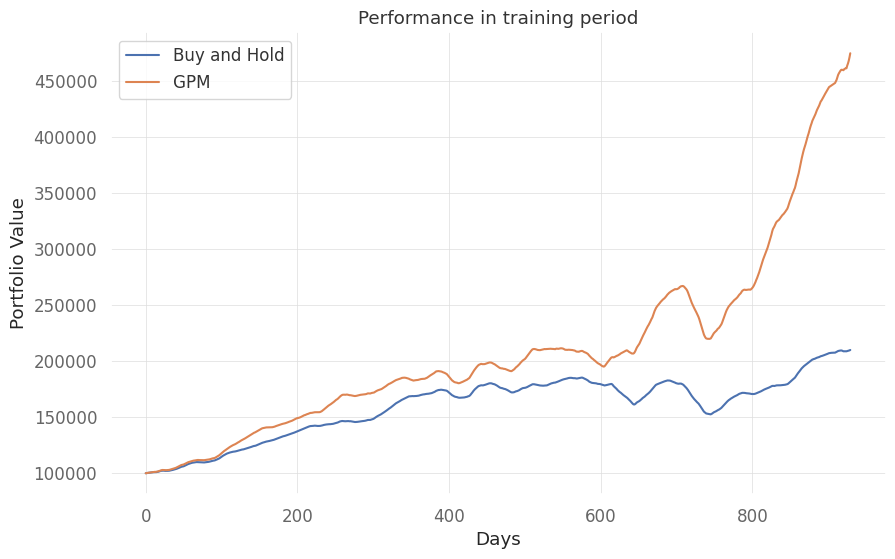

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(GPM_results["train"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

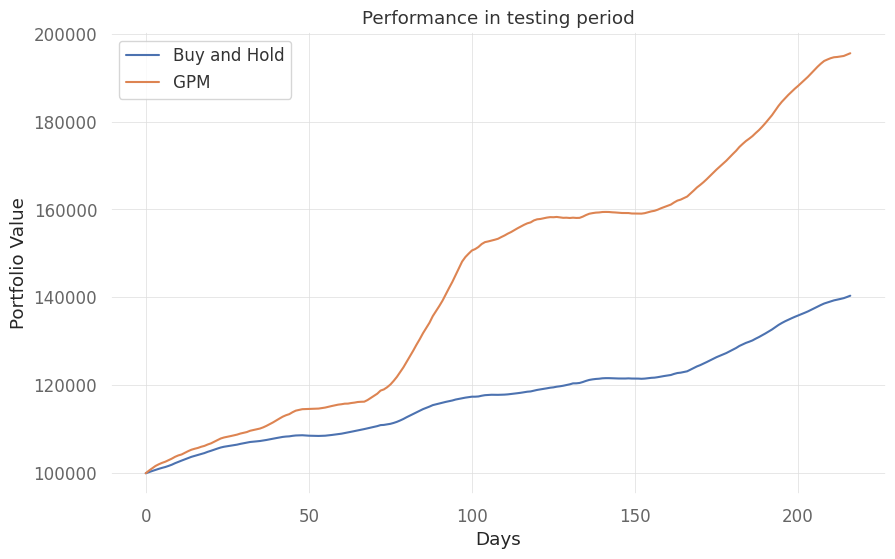

In [32]:
plt.plot(UBAH_results["test"], label="Buy and Hold")
plt.plot(GPM_results["test"], label="GPM")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period")
plt.legend()

plt.show()